![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
TRPO With Generalized Advantage Estimate

Notebook Authors: Jyotirmaya Patra

Adapted from: [Stable Baselines3 Contrib](https://github.com/Stable-Baselines-Team/stable-baselines3-contrib)

Orignal Paper: [Trust Region Policy Optimization](https://arxiv.org/abs/1502.05477)

Additional References:
1. OpenAI SpinningUp:
    * [Trust Region Policy Optimization](https://spinningup.openai.com/en/latest/algorithms/trpo.html)
2. CS 285 at UC Berkeley:
    * [Lecture 9: Advanced Policy Gradients](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-9.pdf) (Lecture recordings also available on Youtube!)
3. Generalised Advantage Estimate:
    * [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438)


## Library Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
import time
import copy
import random
from datetime import datetime
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import utils.helper_fns as hf

import gymnasium as gym
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical


os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'trpo.ipynb'



plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## TRPO Specific Helper Functions

Apart from the general helper functions in `/uitls/helper_fns.py` here you will find helper functions specific to TRPO. Here's a quick preview:
1. `kl_divergence`: compute kl divergence between two pytorch distributions
2. `compute_policy_grad`: compute gradients for kl div and surrogate objective wrt the policy parameters 
3. `hessian_vector_product`: computes the matrix-vector product with the Fisher information matrix.
4. `conjugate_gradient_solver`: finds an approximate solution to a set of linear equations Ax = b

In [2]:
def kl_divergence(dist_true, dist_pred):
    """
    Wrapper for the PyTorch implementation of the full form KL Divergence

    :param dist_true: the p distribution
    :param dist_pred: the q distribution
    :return: KL(dist_true||dist_pred)
    """
    return torch.distributions.kl_divergence(dist_true, dist_pred)


def compute_policy_grad(actor, kl_div, policy_objective):
    """
    Compute gradients for kl div and surrogate objective wrt the policy parameters
    :param actor: actor model in agent
    :param kl_div: The KL divergence objective
    :param policy_objective: The surrogate advantage
    :return: List of actor params, gradients and gradients shape.
    """
    # Contains the gradients of surrogate advantage wrt to each policy parameters
    policy_objective_gradients = []
    # Contains gradients of the KL divergence wrt each policy parameter
    grad_kl = []
    # Save the shape of the gradients of the KL divergence w.r.t each policy parameter
    # Will be used to unflatten the gradients into its original shape later in the training loop
    grad_shape = []
    # List of policy parameters
    actor_params = []

    for param in actor.parameters():
        kl_param_grad, *_ = torch.autograd.grad(
            kl_div,
            param,
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            only_inputs=True
        )

        policy_objective_grad, *_ = torch.autograd.grad(
            policy_objective,
            param,
            retain_graph=True,
            only_inputs=True
        )

        grad_shape.append(kl_param_grad.shape)
        grad_kl.append(kl_param_grad.reshape(-1))
        policy_objective_gradients.append(policy_objective_grad.reshape(-1))
        actor_params.append(param)

    # Concatenate gradients before the conjugate gradient step
    policy_objective_gradients = torch.cat(policy_objective_gradients)
    grad_kl = torch.cat(grad_kl)
    return actor_params, policy_objective_gradients, grad_kl, grad_shape


def hessian_vector_product(params, grad_kl, cg_damping, vector, retain_graph=True):
    """
    Computes the matrix-vector product with the Fisher information matrix.

    :param params: list of parameters used to compute the Hessian
    :param grad_kl: flattened gradient of the KL divergence between the old and new policy
    :param vector: vector to compute the dot product the hessian-vector dot product with
    :param retain_graph: if True, the graph will be kept after computing the Hessian
    :return: Hessian-vector dot product (with damping)
    """
    jacobian_vector_product = (grad_kl * vector).sum()

    hessian_vector_product = torch.autograd.grad(
        jacobian_vector_product,
        params,
        create_graph=False,
        retain_graph=retain_graph,
        allow_unused=True
    )

    hessian_vector_product_flattened = torch.cat([torch.ravel(grad) for grad in hessian_vector_product if grad is not None])
    return hessian_vector_product_flattened + cg_damping * vector


def conjugate_gradient_solver(matrix_vector_dot_fn, b, max_iter=10, residual_tol=1e-10):
    """
    Finds an approximate solution to a set of linear equations Ax = b

    Sources:
     - https://github.com/ajlangley/trpo-pytorch/blob/master/conjugate_gradient.py
     - https://github.com/joschu/modular_rl/blob/master/modular_rl/trpo.py#L122

    Reference:
     - https://epubs.siam.org/doi/abs/10.1137/1.9781611971446.ch6

    :param matrix_vector_dot_fn:
        a function that right multiplies a matrix A by a vector v
    :param b:
        the right hand term in the set of linear equations Ax = b
    :param max_iter:
        the maximum number of iterations (default is 10)
    :param residual_tol:
        residual tolerance for early stopping of the solving (default is 1e-10)
    :return x:
        the approximate solution to the system of equations defined by `matrix_vector_dot_fn`
        and b
    """

    # The vector is not initialized at 0 because of the instability issues when the gradient becomes small.
    # Hence, a small random gaussian noise is used for the initialization.
    x = 1e-4 * torch.randn_like(b)
    residual = b - matrix_vector_dot_fn(x)
    # Equivalent to th.linalg.norm(residual) ** 2 (L2 norm squared)
    residual_squared_norm = torch.matmul(residual, residual)

    if residual_squared_norm < residual_tol:
        # If the gradient becomes extremely small
        # The denominator in alpha will become zero
        # Leading to a division by zero
        return x

    p = residual.clone()

    for i in range(max_iter):
        # A @ p (matrix vector multiplication)
        A_dot_p = matrix_vector_dot_fn(p)

        alpha = residual_squared_norm / p.dot(A_dot_p)
        x += alpha * p

        if i == max_iter - 1:
            return x

        residual -= alpha * A_dot_p
        new_residual_squared_norm = torch.matmul(residual, residual)

        if new_residual_squared_norm < residual_tol:
            return x

        beta = new_residual_squared_norm / residual_squared_norm
        residual_squared_norm = new_residual_squared_norm
        p = residual + beta * p
    # Note: this return statement is only used when max_iter=0
    return x

## Initializations

### Experiment

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook we use a few `edicts` with `exp` being one of them. It is initialized in the following cell and has keys and values containing information about the experiment being run. Although initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports gymnasium environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Discrete`. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0

In [3]:
exp = edict()

exp.exp_name = 'TRPO'  # algorithm name, in this case it should be 'PPO'
exp.env_id = 'CartPole-v1'  # name of the gymnasium environment to be used in this experiment. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

exp.random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 2

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if exp.random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = exp.random_seed

### Rollout Buffer

The second dictionary, `hypp`, is initialized in the following cell. It has keys and values containing the hyperparameters necessary to the algorithm. Similar to the `exp` dict, new keys and values are added to the `hypp` in the later sections. 

Define both `exp.num_envs` and `hypp.num_steps`.

Initialize the multiple environments and run them in parallel using the `SyncVectorEnv` class from the gymnasium library [More info: [Link](https://www.gymlibrary.dev/content/vectorising/)]. 

Next, create a rollout buffer based on the number of parallel envs `exp.num_envs` and the number of steps per env `hypp.num_steps`. It is later used to save episode trajectories during agent training. The buffer gets replaced with new trajectories at the beginning of every iteration of the training loop.

In [4]:
hypp = edict()

exp.num_envs = 4  # number of parallel game environments
hypp.num_steps = 128  # number of steps to run in each environment per policy rollout

# Intialize vectorized gymnasium evn
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])

# RollOut Buffer Init
observations = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
rewards = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
dones = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
values = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)

envs.close()

### Agent Model Class

The `Agent` class consists of a deep MLP value function called the `critic`, and a deep MLP policy called the `actor`, both learned during training. 

The class has three methods:
1. `get_value` method evaluates the `critic` with a given observation (state) to obtain the learned estimate of the observation's value.
2. `get_distribution` method first evaluates the `actor` to obtain the un-normalized probabilities of the actions, which is then used to create a categorical distribution over the actions.
3. `get_action` method returns an action. The method first obtains the categorical distribution over actions the `actor` has learned. Then, if `greedy = True`, it returns the action with the highest probability else, an action sampled from the distribution.
4. `get_action_and_value` method when given an observation, returns the action sampled from the probability distribution (if `action=None`), the respective action's log probability, and the estimate of the observation's value according to the `critic` network.

The `actor` and `critic` networks in the `Agent` class make use of the `layer_init` function to implement ideas derived from [Engstrom, Ilyas, et al., (2020)](https://openreview.net/forum?id=r1etN1rtPB), and [Andrychowicz et al. (2021)](https://openreview.net/forum?id=nIAxjsniDzg). The former introduces the idea of orthogonal initialization of weights for tanh activation. In the latter paper, decision C57 shows that initializing the policy such that the action distribution is centered as zero gives better performance. This is done by initializing the `actor`'s output layer weights with 0.01 std. (see the final layer of `self.actor`)

Note: observation and state mean the same in the context of this notebook

In [5]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_distribution(self, x):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        return probs

    def get_action(self, x, greedy=False):
        distr = self.get_distribution(x)
        action = distr.sample() if not greedy else distr.mode
        return action

    def get_action_and_value(self, x, action=None):
        distr = self.get_distribution(x)
        if action is None:
            action = distr.sample()
        return action, distr.log_prob(action), self.critic(x)

### Training Params & Agent Hyperparams

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - They are stored in the `exp` dict. 
    - This notebook uses tensorboard logging by deafult to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gymnasium videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gymnasium videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.5.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `envs_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gymnasium video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [6]:
# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = False  # disable to speed up training

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 20
exp.device = device.type

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent learning specific flags
hypp.total_timesteps = 500000  # the training duration in number of time steps
hypp.num_minibatches = 4  # number of minibatches for gradient updates
hypp.update_epochs = 10  # only applies to critic updates in TRPO

hypp.batch_size = int(exp.num_envs * hypp.num_steps)  # len of the rollout buffer
hypp.minibatch_size = int(hypp.batch_size // hypp.num_minibatches)  # rollout buffer size / minibatch count

hypp.learning_rate = 1e-3  # size of gradient update step
hypp.anneal_lr = False  # when True reduces the learning rate as the training progresses
hypp.gamma = 0.99  # discount factor over future rewards
hypp.gae_lambda = 0.95  # factor for trade-off bias vs variance for Generalized Advantage Estimator
hypp.norm_adv = True
hypp.cg_max_steps = 10                   # maximum number of steps in the Conjugate Gradient algorithm for computing the Hessian vector product
hypp.cg_damping = 0.1                    # damping in the Hessian vector product computation
hypp.line_search_shrinking_factor = 0.8  # step-size reduction factor for the line-search (i.e., `theta_new = theta + shrinking_factor^i * step`)
hypp.line_search_max_iter = 10           # maximum number of iteration for the backtracking line-search
hypp.target_kl = 0.01  # the target KL divergence threshold for the policy

## Training the Agent
Before we begin training the agent we first initalize the logging (based on the repsective flags in the `exp` dict), object of the `Agent` class and the optimizer, followed by an inital set of observations. 

After that comes the main training loop which is comprised of:  
1. learning rate annealing, 
2. collecting trajectories, ie, filling the rollout buffer with the actor's interaction with the environment,
3. computing the generalized advantage estimate $A^{\pi_{\theta_k}}$ and returns $G$ of the trajectories saved in the rollout buffer,
4. Policy parameters update:
    1. Computing the gradient of the surrogate objective wrt the policy parameters, ie, $g_k = \nabla_{\theta} L_{\pi_{\theta_{k}}}\left(\pi_\theta\right)|_{\theta_{k}}$, where: 
    $$ L_{\pi_{\theta_{k}}}\left(\pi_\theta\right) = \mathbb{E}_{s , a \sim \pi_{\theta_{k}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_k}}(s, a) \right]$$
    2. Computing the Hessian of KL Divergence (also called the Fisher Information Matrix) wrt to policy parameters, ie, $H_k ={\nabla^2_\theta} \bar{D}_{KL}\left(\pi_{\theta_{k}}, \pi_{\theta}\right)$, where
    $$\bar{D}_{KL}\left(\pi_{\theta_{k}}, \pi_{\theta}\right) = \mathbb{E}_{s \sim \pi_{\theta_{k}}}\left[D_{\mathrm{KL}}\left(\pi_{\theta_k}(\cdot \mid s) \| \pi_\theta(\cdot \mid s)\right)\right]$$
    3. Using the conjugate gradient algorithm to compute: $$ x_k \approx H_k^{-1} g_k$$
    4. Updating the policy by bracktracing line search with: $$\theta_{k+1}=\theta_k+\alpha^j \sqrt{\frac{2 \delta}{x_k^T H_k x_k}} x_k $$
5. Critic network update:
    1. Computing the value loss for critic network update, ie, $$L^{V}(s, \theta) = \left(V_{\theta}(s)-G(s)\right)^{2}$$
    2. Perform gradient descent over the critic network `hypp.update_epochs` times wrt the value loss function $L^{V}$.
    
Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`


Note: we have two vectorised gymnasium environments, `envs` and `envs_eval` in the initalizations. `envs` is used to fill the rollout buffer with trajectories and `envs_eval` is used to evaluate the agent performance at different stages of training.

In [7]:
# reinit run_name
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

# Init tensorboard logging and wandb logging
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

# create two vectorized envs: one to fill the rollout buffer with trajectories, and
# another to evaluate the agent performance at different stages of training  
envs.close()
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.eval_count)])

# init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
greedy_evaluation = False  # whether to perform the evaluation in a greedy way or not
eval_max_return = -float('inf')

# Create Agent class Instance and network optimizer
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.critic.parameters(), lr=hypp.learning_rate)

# Init observation to start learning
start_time = time.time()
obs, _ = envs.reset()
obs = torch.Tensor(obs).to(device)
done = torch.zeros(exp.num_envs).to(device)
num_updates = int(hypp.total_timesteps // hypp.batch_size)

global_step = 0
episode_step = 0
gradient_step = 0

pbar = notebook.tqdm(range(1, num_updates + 1))

# training loop
for update in pbar:
    # Annealing the rate if instructed to do so.
    if hypp.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * hypp.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    agent.eval()

    # collect trajectories
    for step in range(0, hypp.num_steps):
        observations[step] = obs
        dones[step] = done

        # sample action and collect value from learned agent policy and value networks
        with torch.no_grad():
            action, logprob, value = agent.get_action_and_value(obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # execute the game and log data.
        next_obs, reward, termianteds, truncateds, infos = envs.step(action.cpu().numpy())
        done = termianteds | truncateds

        agent.eval()
        if "final_observation" in infos.keys():
            for idx, final_obs_single in enumerate(infos["final_observation"]):
                if final_obs_single is not None and truncateds[idx]==True:
                    with torch.no_grad():
                        #Deal with the truncated case
                        terminal_obs = torch.tensor(final_obs_single).to(device)
                        terminal_value = agent.get_value(terminal_obs)
                        reward[idx]+=hypp.gamma * terminal_value

        if "final_info" in infos.keys():
            for idx, final_info_single in enumerate(infos["final_info"]):
                if final_info_single is not None:
                    if "episode" in final_info_single.keys():         
                        pbar.set_description(f"global_step={global_step}, episodic_return={float(final_info_single['episode']['r']):.3f}")
                        writer.add_scalar("rollout/episodic_return", final_info_single["episode"]["r"], global_step)
                        writer.add_scalar("rollout/episodic_length", final_info_single["episode"]["l"], global_step)
                        writer.add_scalar("Charts/episode_step", episode_step, global_step)
                        writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
                        episode_step += 1

        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        global_step += 1 * exp.num_envs
        obs = next_obs

        # generate average performance statistics of current learned agent
        if exp.eval_agent and episode_step % exp.eval_frequency == 0 and last_evaluated_episode != episode_step:
            last_evaluated_episode = episode_step
            tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
            tracked_returns_over_training.append(tracked_return)
            tracked_episode_len_over_training.append(tracked_episode_len)
            tracked_episode_count.append([episode_step, global_step])

            # if there has been improvment of the model -
            if np.mean(tracked_return) > eval_max_return:
                eval_max_return = np.mean(tracked_return)
                # call helper function save_and_log_agent to save model, create video, log video to wandb
                hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=False)

    next_done = done
    agent.train()

    # compute generalised advantage estimate and returns
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(hypp.num_steps)):
            if t == hypp.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + hypp.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + hypp.gamma * hypp.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    with torch.no_grad():
        old_distribution = copy.copy(agent.get_distribution(b_observations))

    distribution = agent.get_distribution(b_observations)
    log_prob = distribution.log_prob(b_actions)

    if hypp.norm_adv:
        b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)

    # ratio between old and new policy, should be one at the start of each iteration
    ratio = torch.exp(log_prob - b_logprobs)

    # compute the surrogate advantage
    policy_objective = (b_advantages * ratio).mean()

    # KL Divergence
    kl_div = kl_divergence(distribution, old_distribution).mean()

    # Compute the gradient of the surroagate advantage and the kl divergence wrt to the policy network parameters
    optimizer.zero_grad()
    actor_params, policy_objective_gradients, grad_kl, grad_shape = compute_policy_grad(agent.actor, kl_div,
                                                                                        policy_objective)

    # Compute search_direction, ie ${H^-1}.{g}$, using the conjugate gradient method
    hessian_vector_product_fn = partial(hessian_vector_product, actor_params, grad_kl, hypp.cg_damping)

    search_direction = conjugate_gradient_solver(
        hessian_vector_product_fn,
        policy_objective_gradients,
        max_iter=hypp.cg_max_steps
    )

    line_search_max_step_size = 2 * hypp.target_kl
    line_search_max_step_size /= torch.matmul(
        search_direction, hessian_vector_product_fn(search_direction, retain_graph=False)
    )
    line_search_max_step_size = torch.sqrt(line_search_max_step_size)

    line_search_backtrack_coeff = 1.0
    original_actor_params = [param.detach().clone() for param in actor_params]

    policy_objective_values = []  # average value of the surrogate advantage
    kl_divergences = []  # average KL-divergence between policies across states visited by the old policy

    is_line_search_success = False
    with torch.no_grad():
        # update policy parameters by backtracking line-search
        for _ in range(hypp.line_search_max_iter):

            start_idx = 0
            # Applying the scaled step direction
            for param, original_param, shape in zip(actor_params, original_actor_params, grad_shape):
                n_params = param.numel()
                param.data = (
                        original_param.data
                        + line_search_backtrack_coeff
                        * line_search_max_step_size
                        * search_direction[start_idx: (start_idx + n_params)].view(shape)
                )
                start_idx += n_params

            # Recomputing the policy log-probabilities
            distribution = agent.get_distribution(b_observations)
            log_prob = distribution.log_prob(b_actions)

            # New policy objective
            ratio = torch.exp(log_prob - b_logprobs)
            new_policy_objective = (b_advantages * ratio).mean()

            # New KL-divergence
            kl_div = kl_divergence(distribution, old_distribution).mean()

            # Constraint criteria:
            # we need to improve the surrogate policy objective
            # while being close enough (in terms of kl div) to the old policy
            if (kl_div < hypp.target_kl) and (new_policy_objective > policy_objective):
                is_line_search_success = True
                break

            # Reducing step size if line-search wasn't successful
            line_search_backtrack_coeff *= hypp.line_search_shrinking_factor

        if not is_line_search_success:
            # If the line-search wasn't successful we revert to the original parameters
            for param, original_param in zip(actor_params, original_actor_params):
                param.data = original_param.data.clone()

            policy_objective_values = policy_objective.item()
            kl_divergences = 0
        else:
            policy_objective_values = new_policy_objective.item()
            kl_divergences = kl_div.item()

    b_inds = np.arange(hypp.batch_size)

    value_losses = []

    # update the critic network
    for i in range(hypp.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, hypp.batch_size, hypp.minibatch_size):
            end = start + hypp.minibatch_size
            mb_inds = b_inds[start:end]

            newvals = agent.get_value(b_observations[mb_inds])
            newvals = newvals.view(-1)

            v_loss = 0.5 * ((newvals - b_returns[mb_inds]) ** 2).mean()

            optimizer.zero_grad()
            v_loss.backward()
            optimizer.step()

            value_losses.append(v_loss.item())
            gradient_step += 1

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # log losses to tensorboard summary writer
    writer.add_scalar("hyperparameters/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("train/value_loss", np.mean(value_losses), global_step)
    writer.add_scalar("train/kl_divergence", kl_divergences, global_step)
    writer.add_scalar("train/explained_variance", explained_var, global_step)
    writer.add_scalar("train/is_line_search_success", int(is_line_search_success), global_step)
    writer.add_scalar("train/surrogate_objective", policy_objective_values, global_step)
    writer.add_scalar("Charts/episode_step", episode_step, global_step)
    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)

# one last evaluation stage
if exp.eval_agent:
    last_evaluated_episode = episode_step
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvment of the model -
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function save_and_log_agent to save model, create video, log video to wandb
        hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=True)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training, tracked_episode_count, exp.eval_count, exp.run_name, exp.exp_type)

envs.close()
envs_eval.close()
writer.close()
if wandb.run is not None:
    wandb.finish()
    wandb.init(mode="disabled")

hf.save_train_config_to_yaml(exp, hypp)

wandb: Currently logged in as: artur-eisele to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/976 [00:00<?, ?it/s]

Charts/episode_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
Charts/gradient_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
global_step,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
hyperparameters/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/episodic_length,▁▂▅▆▇█████████████████████████▃█████████
rollout/episodic_return,▂▁▁▁▂▃▅██████████████████▄██▅███████████
train/explained_variance,██▆▅▄▃▅▃▄▁▆▇▇▂▃▇▆▁▆▅▃▆▄▆▇███████▇███▄▆▄▇
train/is_line_search_success,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/kl_divergence,▅▅▆▄▇▅▅▅█▇▄▇█▃▄▄▇▅▅█▇█▁▂▃▃▇▆▇▇▇▅▇▇▇▅▇▇▅▅
train/surrogate_objective,█▃▃▃▃▃▂▆▂▇▃▂▁▄▁▃█▃▁▃▂▂▅▆▄▃▁▃▂▃▃▂▂▅▁▂▂▂▁▃
train/value_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁


## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behaviour

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gymnasium environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the following directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [8]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location


exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True)

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved as a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

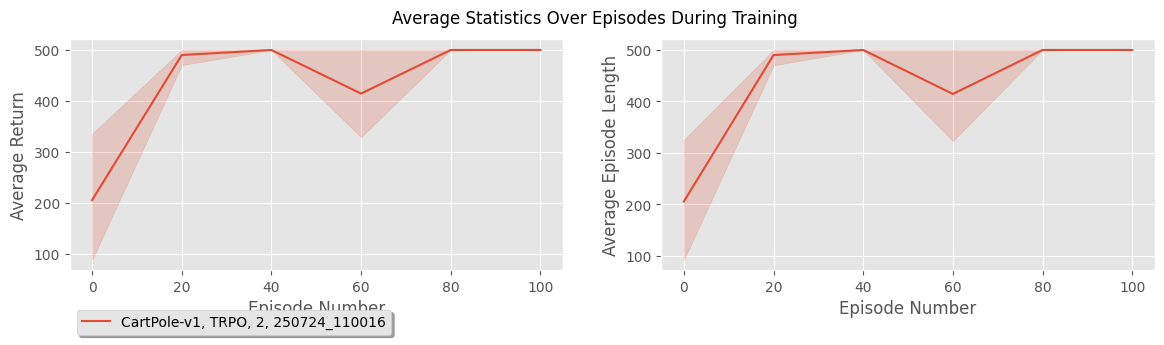

In [9]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = exp.run_name
eval_params.exp_type00 = exp.exp_type

# eval_params.run_name01 = "CartPole-v1__PPO__1__230323_224300"
# eval_params.exp_type01 = None 

# eval_params.run_name02 = "CartPole-v1__PPO__1__230302_221245"
# eval_params.exp_type02 = None

agent_labels = []

episode_axis_limit = None

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir logs --host localhost